<a href="https://colab.research.google.com/github/victoryforphil/VictoryCar-UNetModels/blob/master/UNet_Car_Small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://storage.googleapis.com/victorycar-trainingdata/bdd100k_images.zip
!wget https://storage.googleapis.com/victorycar-trainingdata/bdd100k_labels_release.zip
!unzip bdd100k_labels_release.zip
!unzip -q bdd100k_images.zip
!pip install keras_tqdm

--2019-04-10 21:43:34--  https://storage.googleapis.com/victorycar-trainingdata/bdd100k_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c0e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6941520264 (6.5G) [application/x-zip-compressed]
Saving to: ‘bdd100k_images.zip’

bdd100k_images.zip  100%[===================>]   6.46G  84.7MB/s    in 56s     

2019-04-10 21:44:31 (117 MB/s) - ‘bdd100k_images.zip’ saved [6941520264/6941520264]

--2019-04-10 21:44:32--  https://storage.googleapis.com/victorycar-trainingdata/bdd100k_labels_release.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 2607:f8b0:4001:c18::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111500269 (106M) [application/x-zip-compress

In [0]:
import cv2
import pandas
import numpy as np
import keras
import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as keras
from skimage.draw import line
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [0]:
LABEL_PATH = 'bdd100k/labels/'
LABEL_VAL_PATH = LABEL_PATH + 'bdd100k_labels_images_val.json'
LABEL_TRAIN_PATH = LABEL_PATH + 'bdd100k_labels_images_train.json'
DATA_PATH_TRAIN = 'bdd100k/images/100k/train/'
DATA_PATH_VAL = 'bdd100k/images/100k/val/'
VAL_LOAD = 200
TRAIN_LOAD = 1100

IMAGE_SIZE_Y = 256
IMAGE_SIZE_X = 512

In [0]:
def load_label(path, to_load):
  count = 0
  with open(path) as json_file:  
    data = json.load(json_file)
    
    formatted_data = []
    
    for entry in tqdm(data):
      
      if count > to_load:
        continue
      
      image_name = entry['name']
      labels = entry['labels']
      
      cars = []
      for label in labels:
        cat = label['category']
      
       
        if cat not in 'car':
          continue
        #print(label)
        seen = label['attributes']['occluded']
        seen = True
        #print(area_type)
        if seen:
          box = [(label['box2d']['x1'] + 5,label['box2d']['y1'] + 5), (label['box2d']['x2'] -5, label['box2d']['y2'] -5)]
         
          cars.append(box)
        
      
      formatted_data.append([image_name, cars])
      count += 1
     
    print("Loaded " + str(len(formatted_data)) + " entries")
    return formatted_data
      
val_labels = load_label(LABEL_VAL_PATH, VAL_LOAD)
train_labels = load_label(LABEL_TRAIN_PATH, TRAIN_LOAD)
print(val_labels[1])



Loaded 201 entries



Loaded 1101 entries
['b1c81faa-3df17267.jpg', [[(824.464053, 285.082505), (884.23726, 307.742305)], [(1032.299139, 295.47426), (1047.536255, 301.804159)]]]


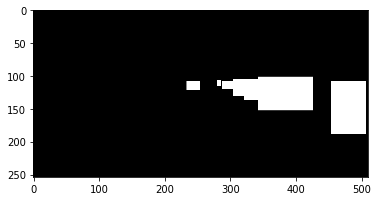

In [0]:
DOWNSCALE = 1

def label_to_image(label):
  cars = label[1]
 
  image = np.zeros([int(720 / DOWNSCALE),int(1280 / DOWNSCALE),3])
  
  for box in cars:
    box = np.array(box, dtype=np.int32)

    image = cv2.rectangle(image,(box[0][0],box[0][1]),(box[1][0],box[1][1]), (1.0,1.0,1.0), cv2.FILLED)
    
  
  image = cv2.resize(image, (IMAGE_SIZE_X - 2,IMAGE_SIZE_Y -2))
  return image

y1 = []
for label in tqdm(train_labels):
  y1.append(label_to_image(label))

y2 = []
for label in tqdm(val_labels):
  y2.append(label_to_image(label))

plt.imshow(y1[2])


In [0]:
def load_image(path):
  img = load_img(path)
  
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = cv2.resize(x, (IMAGE_SIZE_X,IMAGE_SIZE_Y))
  
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  x = x / 255
  
  return x

def load_images (dir, labels):
  
  images = []
  for label in tqdm(labels):
    image = label[0]
    path = dir + image
    
    images.append(load_image(path))
    
  return images


  
x1 = load_images(DATA_PATH_TRAIN, train_labels)
x2 = load_images(DATA_PATH_VAL, val_labels)


In [0]:
x1 = np.array(x1)
x2 = np.array(x2)
x1 = x1.reshape(len(x1),IMAGE_SIZE_Y,IMAGE_SIZE_X,3)
x2 = x2.reshape(len(x2),IMAGE_SIZE_Y,IMAGE_SIZE_X,3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


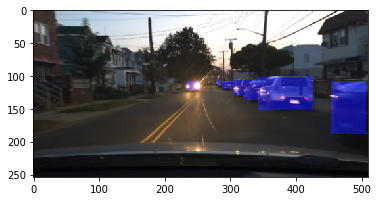

In [0]:
y = y1[2]
x = x1[2]
x = cv2.resize(x, (IMAGE_SIZE_X -2,IMAGE_SIZE_Y -2))
x = np.array([x])
x = x.reshape(len(x),IMAGE_SIZE_Y -2,IMAGE_SIZE_X -2,3)
combined = x[0] + (y * (0,0,0.5))
plt.imshow(combined)

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

def unet(pretrained_weights = None,input_size = (IMAGE_SIZE_Y,IMAGE_SIZE_X,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 3, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 5e-4), loss = 'binary_crossentropy', metrics = [dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
      print('Loading Weights from ' + pretrained_weights)
      model.load_weights(pretrained_weights)

    return model
  
  
model = unet()#'unet_car_small-weights.hdf5'
model_json = model.to_json()
with open("unet_car_small-model.json", "w") as json_file:
    json_file.write(model_json)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


1/1 [==============================] - 6s 6s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


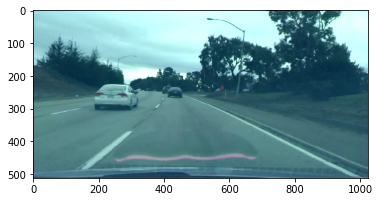

In [0]:
def predict_model():
  test_image = load_image('bdd100k/images/10k/test/bd46c997-00000000.jpg')
  
  test = np.array([test_image])
  test = test.reshape(len(test),IMAGE_SIZE_Y,IMAGE_SIZE_X,3)
  lanes = model.predict(test, verbose=1)
 
  y = lanes

  x = cv2.resize(test[0], (IMAGE_SIZE_X-2,IMAGE_SIZE_Y - 2))
  x = np.array([x])
  x = x.reshape(len(x),IMAGE_SIZE_Y - 2,IMAGE_SIZE_X-2,3)
  combined = x[0] + (y*(0,0.3,0.5))
  
  combined = combined[0]
  
  combined = cv2.resize(combined, (1024,512))
  
  
  
  return combined

plt.imshow(predict_model())

In [0]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:

class Predict(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
      lanes = predict_model()
      plt.imshow(lanes)
      print(lanes.shape)
      plt.savefig('result-' + str(epoch)+'.png')
      return

model_checkpoint = ModelCheckpoint('unet_car_small-weights.hdf5', monitor='loss',verbose=1, save_best_only=True)

predict_cb = Predict()

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=1,
                         write_images=True)

model.fit([x1],[y1],validation_data=([x2],[y2]), batch_size=1, epochs=50, verbose=1, shuffle=True, callbacks=[model_checkpoint, predict_cb, tbCallBack])

Instructions for updating:
Use tf.cast instead.
Train on 1101 samples, validate on 201 samples
Epoch 1/50
1101/1101 [==============================] - 195s 177ms/step - loss: 0.3773 - dice_coef: 0.1083 - val_loss: 0.2831 - val_dice_coef: 0.1312

Epoch 00001: loss improved from inf to 0.37726, saving model to unet_car_small-weights.hdf5
1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 1024, 3)
Epoch 2/50
1101/1101 [==============================] - 193s 176ms/step - loss: 0.2706 - dice_coef: 0.1272 - val_loss: 0.2727 - val_dice_coef: 0.1279

Epoch 00002: loss improved from 0.37726 to 0.27056, saving model to unet_car_small-weights.hdf5
1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 1024, 3)


In [0]:
test_image = load_image('bdd100k/images/10k/test/b432340b-00000000.jpg')
test = np.array([test_image])
test = test.reshape(len(test),128,256,3)
lanes = model.predict(test)
print(lanes.shape)
plt.imshow(test[0])

In [0]:
plt.imshow(lanes[0])